[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_09_redes_neuronales-published.ipynb)

# Redes neuronales


Vamos nuevamente a trabajar con los datos de `iris` para entrenar (y antes construir) una Red Neuronal.

In [69]:
import sklearn

In [70]:
from sklearn.preprocessing import LabelEncoder #es para transformar las etiquetas en valores numéricos
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

def get_data():
    dataset = load_iris()
    X = dataset["data"]
    y = dataset["target"] #estaba en formato string, del tipo de flor, que eran 3 tipos: setosa, versicolor, virginica
    y = LabelEncoder().fit_transform(y) #lo transforma a un valor numérico
    return np.array(X), np.array(y)
X, y = get_data()
X
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

La propuesta es empezar por el esqueleto de las 2 clases que usaremos para esta tarea e ir implementado los métodos a medida que avancemos.

Al final de este notebook se encuentran ambas clases completas. Pueden copiar el código desde allí mismo o implementarlo. La idea es que en cada avance podamos comprender la parte del proceso que estamos realizando, por lo cual se recomienda seguir la guia propuesta e ir completando sólo lo que es necesario para cada punto.

In [71]:
class Capa:
    def __init__(self, neuronas):
        self.neuronas = neuronas

    def forward(self, inputs, weights, bias, activation):
        """
        Forward Propagation de la capa
        """
        Z_curr = np.dot(inputs, weights.T) + bias #Z = XW + b

        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr) #A = ReLU(Z)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr) #A = Softmax(Z)

        return A_curr, Z_curr
        
    def relu(self, inputs):
        """
        ReLU: función de activación
        """

        return np.maximum(0, inputs)

    def softmax(self, inputs):
        """
        Softmax: función de activación
        """
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        """
        Backward Propagation de la capa
        """
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(dA_curr, W_curr) 
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W_curr)
            
        return dA, dW, db

    def relu_derivative(self, dA, Z):
        """
        ReLU: gradiente de ReLU
        """
        dZ = np.array(dA, copy = True) #copia el vector
        dZ[Z <= 0] = 0 #a los negativos les asigna 0
        dZ[Z > 0] = 1 #a los positivos les asigna 1
        return dZ

In [99]:
class RedNeuronal:
    def __init__(self, learning_rate=0.01):
        self.red = [] ## capas
        self.arquitectura = [] ## mapeo de entradas -> salidas
        self.pesos = [] ## W, b
        self.memoria = [] ## Z, A
        self.gradientes = [] ## dW, db
        self.lr = learning_rate
        
    def add(self, capa):
        """
        Agregar capa a la red
        """
        self.red.append(capa) #agregamos una capa a la red
            
    def _compile(self, data):
        """
        Inicializar la arquitectura
        """
        for idx, _ in enumerate(self.red):
            if idx == 0:
                self.arquitectura.append({'input_dim': data.shape[1], 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            elif idx > 0 and idx < len(self.red)-1:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas, 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            else:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas, 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'softmax'})
    
    def _init_weights(self, data):
        """
        Inicializar arquitectura y los pesos
        """
        self._compile(data)

        np.random.seed(99)

        for i in range(len(self.arquitectura)):
            self.pesos.append({
                'W':np.random.uniform(low=-1, high=1, 
                        size=(self.arquitectura[i]['input_dim'],
                            self.arquitectura[i]['output_dim']
                            )),
                'b':np.zeros((1, self.arquitectura[i]['output_dim']))})

        return self
    
    def _forwardprop(self, data):
        """
        Pasada forward completa por la red
        """
        A_curr = data 

        for i in range(len(self.pesos)):
            A_prev = A_curr
            A_curr, Z_curr = self.red[i].forward(inputs=A_prev, 
                                                    weights=self.pesos[i]['W'].T, 
                                                    bias=self.pesos[i]['b'], 
                                                    activation=self.arquitectura[i]['activation'])

            self.memoria.append({'inputs':A_prev, 'Z':Z_curr})

        return A_curr
    
    def _backprop(self, predicted, actual):
        """
        Pasada backward completa por la red
        """
        num_samples = len(actual)

        ## compute the gradient on predictions
        dscores = predicted #softmax output
        dscores[range(num_samples),actual] -= 1 #derivada de la función de pérdida
        dscores /= num_samples #normalizar

        dA_prev = dscores #dA de la última capa

        for idx, layer in reversed(list(enumerate(self.red))):
            dA_curr = dA_prev

            A_prev = self.memoria[idx]['inputs']
            Z_curr = self.memoria[idx]['Z']
            W_curr = self.pesos[idx]['W']

            activation = self.arquitectura[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr.T, Z_curr, A_prev, activation)

            self.gradientes.append({'dW':dW_curr, 'db':db_curr})

        self.gradientes = list(reversed(self.gradientes))  # Reverse the gradients list
            
    def _update(self):
        """
        Actualizar el modelo --> lr * gradiente
        """
        lr = self.lr
        for idx, layer in enumerate(self.red):
            self.pesos[idx]['W'] -= lr * self.gradientes[idx]['dW']
            self.pesos[idx]['b'] -= lr * self.gradientes[idx]['db']

    def _get_accuracy(self, predicted, actual):
        """
        Calcular accuracy después de cada iteración
        """
        return np.mean(np.argmax(predicted, axis=1)==actual)
        
    def _calculate_loss(self, predicted, actual):
        """
        Calculate cross-entropy loss after each iteration
        """
        samples = len(actual)

        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss

    def train(self, X_train, y_train, epochs):
        """
        Entrenar el modelo Stochastic Gradient Descent
        """
        self.loss = []
        self.accuracy = []

        self._init_weights(X_train)

        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))

            self._backprop(predicted=yhat, actual=y_train)

            self._update()

            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

        return (self.accuracy, self.loss)

1.

In [73]:
red = RedNeuronal(learning_rate=0.01)
neuronas = [6,8,10,3]
for neurona in neuronas:
    capa = Capa(neurona)
    red.add(capa)
    
#red._compile(X)

In [74]:
red.arquitectura #es lo que nos pedían en el enunciado

[]

2.

In [75]:
red._init_weights(X)

3.

In [76]:
prueba = np.array([[1.3, 5.1, -2.2, 0.7, 1.1]])
capa = Capa(5)
capa.relu(prueba)

array([[1.3, 5.1, 0. , 0.7, 1.1]])

In [77]:
prueba = np.array([[1.3, 5.1, -2.2, 0.7, 1.1]])
capa = Capa(5)
capa.softmax(prueba)

array([[2.12319074e-02, 9.49091411e-01, 6.41148049e-04, 1.16523179e-02,
        1.73832156e-02]])

In [78]:
red._forwardprop(X).shape

(150, 3)

In [79]:
X.shape

(150, 4)

In [80]:
print(red._forwardprop(X)[0])
print(y[0])

[0.16617107 0.81859653 0.0152324 ]
0


4. 
Respuestas:
1. Nos devuelve una matriz de #instancias x #clases, en este caso, tenemos 3 clases, cada tipo de flor.
2. Para cada fila, es decir, cada instancia, tenemos la probabilidad de pertenecer a cada una de las clases.
3. Nos da los resultados: [0.16617107, 0.81859653, 0.0152324 ], lo que nos dice que el más probable versicolor. Sin embargo, el real es 0 (setosa). La razón por la cual da tan mal, es porque el modelo no está entrenado.

5.
1. Para los negativos asigna 0 y para los positivos asigna 1. Pero en el código teníamos que a los positivos los dejaba como estaba, por eso había que completar con:
dZ[Z > 0] = 1 #a los positivos les asigna 1
2. La operación matemática son todas las derivadas necesarias.
3. En predicted le tenemos que pasar el resultado de _forwardprop(...) y en actual le pasamos y.
4. veamoslo:

In [81]:
red._backprop(red._forwardprop(X), y)

In [98]:
#como miro el shape de cada elemento del diccionario
for i in range(len(red.gradientes)):
    print(red.gradientes[i]['dW'].shape)
    print(red.gradientes[i]['db'].shape)

#red.gradientes

(4, 6)
(1, 6)
(6, 8)
(1, 8)
(8, 10)
(1, 10)
(10, 3)
(1, 3)


6.
update: actualiza los pesos del modelo en base al gradiente y el learning rate, que es el paso.

get_accuracy: calcula el accuracy 

calculate_loss: calcula la entropía cruzada 

7.
1. Los valores que se imprimen son dada la epoca:
* el valor del accuracy para esa época
* el valor de la función de pérdida usando entropía cruzada para esa época
Vemos que desde la época 20 no cambia el accuracy y cambian muy pocos decimales de la función de costo (casi nada). 

In [100]:
red_final = RedNeuronal(learning_rate=0.01)
neuronas = [6,8,10,3]
for neurona in neuronas:
    capa = Capa(neurona)
    red_final.add(capa)

red_final.train(X, y, 200)

EPOCH: 0, ACCURACY: 0.25333333333333335, LOSS: 2.537401260962661
EPOCH: 20, ACCURACY: 0.3333333333333333, LOSS: 1.0986147070059744
EPOCH: 40, ACCURACY: 0.3333333333333333, LOSS: 1.0986144044434354
EPOCH: 60, ACCURACY: 0.3333333333333333, LOSS: 1.0986141397473594
EPOCH: 80, ACCURACY: 0.3333333333333333, LOSS: 1.0986139081764237
EPOCH: 100, ACCURACY: 0.3333333333333333, LOSS: 1.0986137055833822
EPOCH: 120, ACCURACY: 0.3333333333333333, LOSS: 1.0986135283405558
EPOCH: 140, ACCURACY: 0.3333333333333333, LOSS: 1.0986133732746752
EPOCH: 160, ACCURACY: 0.3333333333333333, LOSS: 1.0986132376099178
EPOCH: 180, ACCURACY: 0.3333333333333333, LOSS: 1.0986131189180834


([0.25333333333333335,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.33333

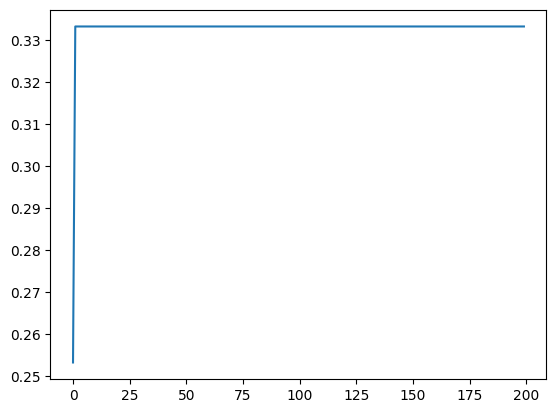

In [106]:
plt.plot(range(0,200),red_final.accuracy)
plt.show()

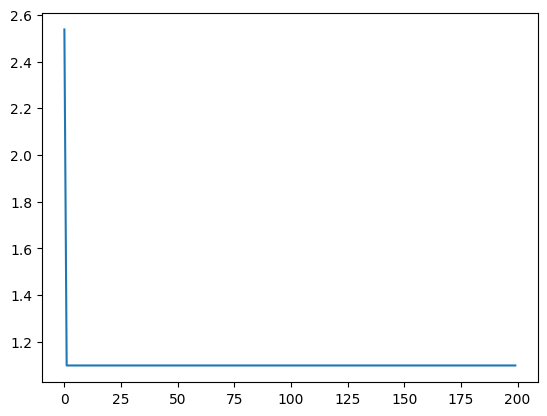

In [107]:
plt.plot(range(0,200),red_final.loss)
plt.show()

Los items que se presentan a continuación tienen como objetivo explorar las clases que componen la red neuronal propuesta, comprender su arquitectura y funcionamiento.

Nuevamente, lo ideal es no mirar todos los métodos hasta que llegue el momento de utilizarlos. 

1. Crear una Red Neuronal con 6 nodos en la primera capa, 8 en la segunda, 10 en la tercer y finalmente 3 en la última, utilizando los métodos `add()`, `_compile()` de la clase `RedNeuronal` y el constructor de la clase `Capa`.
  
    Imprimir la arquitectura del modelo y asegurarse de obtener:

    ```
    [{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'},
    {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'},
    {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'},
    {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]
    ```

    Dibujar la red en papel.

1. Inicializar los pesos de la red del punto anterior (`_init_weights(datos)`) y verificar que los pesos tienen dimensión correcta:

    ```
    capa 0: w=(4, 6) - b=(1, 6)
    capa 1: w=(6, 8) - b=(1, 8)
    capa 2: w=(8, 10) - b=(1, 10)
    capa 3: w=(10, 3) - b=(1, 3)
    ```

    Definir las matrices que se corresponden con las capas de manera que una pasada pueda ser interpretada como el producto de todas ellas. Recordar que en cada paso por cada capa estaremos computando por cada neurona de la capa siguiente:

    $$Z = \sum_{i=1}^{n} X_i \times W_i + b$$

1. Funciones de activación de una `Capa`:

    1. Verificar que el funcionamiento de `ReLU` se corresponda con:

        ```
        if input > 0:
            return input
        else:
            return 0
        ``` 

    1. Verificar que el funcionamiento de `softmax` se corresponda con:

        $$\sigma(Z)_i = \frac{e^{z_i}}{\sum_{i=1}^{n} e^{z_j}}$$

    **Nota**: para probar estos dos métodos puede ser util construir un vector de la siguiente manera: `np.array([[1.3, 5.1, -2.2, 0.7, 1.1]])` que genera un vector de tamaño (1,5).

1. Avancemos con `_forwardprop(datos)`, si corremos la red inicializada con los datos:

    1. ¿Qué nos tipo de objeto nos devuelve este método?

    1. ¿Qué quiere decir cada uno de los valores?

    1. La primera fila, que se correspondería con la primera observación del dataset, ¿qué resultados nos da?¿qué es más probable: 'setosa', 'versicolor' o 'virginica'?¿qué valor es el real?¿por qué?

1. Arrancamos a propagar para atrás lo aprendido en la primera pasada. Esto lo realizaremos con el método `_backprop`.

    1. ¿Cómo es la derivada de la función de activación `ReLU`?¿Su código es correcto?

    1. ¿Cuál es la operación matemática que hace la función `backward` de la clase `Capa` en el caso de tener como activación a `relu`?

    1. El método `_backprop` toma 2 parámetros: `predicted` y `actual`. ¿qué debemos pasarle en dicho lugar?

        Si la respuesta no fue: en `predicted` le pasamos el resultado de `_forwardprop(...)` y en `actual` le pasamos `y`.... volver a pensarlo. ;-)

    1. Verificar que los `gradientes` y los `pesos` para cada una de las capas tienen el mismo tamaño.

1. Preparemos por último las funciones necesarias para el entrenamiento. Describir brevemente qué hacen las funciones:

    - `_get_accuracy`
    - `_calculate_loss`
    - `_update`

1. Incluyamos finalmente la función `train` y entrenemos una red con la arquitectura propuesta en el punto 1 por 200 epocas.

    1. ¿Qué valores se imprimen?¿Qué es posible interpretar de ellos?

    1. Graficar el _accuracy_ y la _loss_ que arroja el entramiento en función de las _epochs_. ¿Qué se puede concluir? Probablemente la señal sea ruidosa, por lo que se recomienda hacer un suavizado por ventanas deslizantes.


Crédito: este ejercicio se base en la propuesta de Joe Sasson publicada en [Towards Data Science](https://towardsdatascience.com/coding-a-neural-network-from-scratch-in-numpy-31f04e4d605).

### Código completo


In [390]:
class Capa:
    def __init__(self, neuronas):
        self.neuronas = neuronas

    def forward(self, inputs, weights, bias, activation):
        """
        Forward Propagation de la capa
        """
        Z_curr = np.dot(inputs, weights.T) + bias

        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)

        return A_curr, Z_curr

    def relu(self, inputs):
        """
        ReLU: función de activación
        """

        return np.maximum(0, inputs)

    def softmax(self, inputs):
        """
        Softmax: función de activación
        """
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
         
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        """
        Backward Propagation de la capa
        """
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(dA_curr, W_curr) 
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W_curr)
            
        return dA, dW, db

    def relu_derivative(self, dA, Z):
        """
        ReLU: gradiente de ReLU
        """
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    

In [13]:
class RedNeuronal:
    def __init__(self, learning_rate=0.01):
        self.red = [] ## capas
        self.arquitectura = [] ## mapeo de entradas -> salidas
        self.pesos = [] ## W, b
        self.memoria = [] ## Z, A
        self.gradientes = [] ## dW, db
        self.lr = learning_rate
        
    def add(self, capa):
        """
        Agregar capa a la red
        """
        self.red.append(capa)
            
    def _compile(self, data):
        """
        Inicializar la arquitectura
        """
        for idx, _ in enumerate(self.red):
            if idx == 0:
                self.arquitectura.append({'input_dim': data.shape[1], 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            elif idx > 0 and idx < len(self.red)-1:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas, 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            else:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas, 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'softmax'})
        return self

    def _init_weights(self, data):
        """
        Inicializar arquitectura y los pesos
        """
        self._compile(data)

        np.random.seed(99)

        for i in range(len(self.arquitectura)):
            self.pesos.append({
                'W':np.random.uniform(low=-1, high=1, 
                        size=(self.arquitectura[i]['input_dim'],
                            self.arquitectura[i]['output_dim']
                            )),
                'b':np.zeros((1, self.arquitectura[i]['output_dim']))})

        return self
    
    def _forwardprop(self, data):
        """
        Pasada forward completa por la red
        """
        A_curr = data

        for i in range(len(self.pesos)):
            A_prev = A_curr
            A_curr, Z_curr = self.red[i].forward(inputs=A_prev, 
                                                    weights=self.pesos[i]['W'].T, 
                                                    bias=self.pesos[i]['b'], 
                                                    activation=self.arquitectura[i]['activation'])

            self.memoria.append({'inputs':A_prev, 'Z':Z_curr})

        return A_curr
    
    def _backprop(self, predicted, actual):
        """
        Pasada backward completa por la red
        """
        num_samples = len(actual)

        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples

        dA_prev = dscores

        for idx, layer in reversed(list(enumerate(self.red))):
            dA_curr = dA_prev

            A_prev = self.memoria[idx]['inputs']
            Z_curr = self.memoria[idx]['Z']
            W_curr = self.pesos[idx]['W']

            activation = self.arquitectura[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr.T, Z_curr, A_prev, activation)

            self.gradientes.append({'dW':dW_curr, 'db':db_curr})

        self.gradientes = list(reversed(self.gradientes))  # Reverse the gradients list

    def _update(self):
        """
        Actualizar el modelo --> lr * gradiente
        """
        lr = self.lr
        for idx, layer in enumerate(self.red):
            self.pesos[idx]['W'] -= lr * self.gradientes[idx]['dW']
            self.pesos[idx]['b'] -= lr * self.gradientes[idx]['db']

    def _get_accuracy(self, predicted, actual):
        """
        Calcular accuracy después de cada iteración
        """
        return np.mean(np.argmax(predicted, axis=1)==actual)
        
    def _calculate_loss(self, predicted, actual):
        """
        Calculate cross-entropy loss after each iteration
        """
        samples = len(actual)

        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss

    def train(self, X_train, y_train, epochs):
        """
        Entrenar el modelo Stochastic Gradient Descent
        """
        self.loss = []
        self.accuracy = []

        self._init_weights(X_train)

        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))

            self._backprop(predicted=yhat, actual=y_train)

            self._update()

            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

        return (self.accuracy, self.loss)

In [ ]:
from graphviz import Digraph, Graph

def dibujar_red(red):
    dot = Graph()
    dot.attr(rankdir="LR")
    dot.attr(splines="false")
    dot.attr(nodesep="0.05")
    
    for idx,capa in enumerate(red.arquitectura):
        with dot.subgraph(name=f'cluster_{idx}') as c:
            c.attr(rank="same")
            for i in range(capa['input_dim']+1):
                c.node(nombre_nodo(idx, i), label=etiqueta_nodo(idx,i))

            c.attr(color='white')
            
            label_extra = "Entrada" if idx == 0 else "Oculta\n(ReLU)"
        
            c.attr(label=f'capa {idx+1}\n{label_extra}')

    with dot.subgraph(name=f'cluster_{idx+1}') as c:
            c.attr(rank="same")
            for i in range(capa['output_dim']):
                c.node(nombre_nodo(idx+1, i), label=etiqueta_nodo(idx+1,i, True))

            c.attr(color='white')
            
            label_extra = "Salida\n(SoftMax)"
        
            c.attr(label=f'capa {idx+1}\n{label_extra}')

    for idx, capa in enumerate(red.arquitectura):
        for in_idx in range(capa["input_dim"]+1):
            for out_idx in range(capa["output_dim"]):
                to_node = (idx+1, out_idx+1) if idx!=len(red.arquitectura)-1 else (idx+1, out_idx)
                dot.edge(nombre_nodo(idx, in_idx), 
                         nombre_nodo(*to_node))

    return dot

def nombre_nodo(capa, indice):
    res = f"c_{capa}_{indice}"
    return res

def etiqueta_nodo(capa, indice, es_final=False):
    if indice==0 and not es_final:
        return "1"
    l = "a" if capa!=0 else "x"
    l = l if not es_final else "y"
    
    if l=="x" or l=="y":    
        return f"<{l}<sub>{indice}</sub>>"
    else:
        return f"<{l}<sub>{indice}</sub><sup>({capa})</sup>>"

# model = RedNeuronal()
# model.add(...)
# model._compile(...datos...)

dibujar_red(model)